In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import sys

In [3]:
data = pd.read_csv("drive/MyDrive/mlpregressor_odev/Admission_Predict.csv")
print(data.describe())
print(data.info())
data.drop('Serial No.',axis=1,inplace=True)
train = data[0:320]
val = data[320:360]
test = data[360:400]
target_fields = ['Chance of Admit ']
train_ft, train_tg = train.drop(target_fields, axis=1), train[target_fields]
test_ft, test_tg = test.drop(target_fields, axis=1), test[target_fields]
val_ft, val_tg = val.drop(target_fields, axis=1), val[target_fields]
train_ft = train_ft / train_ft.max()
test_ft = test_ft / test_ft.max()
val_ft = val_ft / val_ft.max()

       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  400.000000  400.000000   400.000000         400.000000  400.000000   
mean   200.500000  316.807500   107.410000           3.087500    3.400000   
std    115.614301   11.473646     6.069514           1.143728    1.006869   
min      1.000000  290.000000    92.000000           1.000000    1.000000   
25%    100.750000  308.000000   103.000000           2.000000    2.500000   
50%    200.500000  317.000000   107.000000           3.000000    3.500000   
75%    300.250000  325.000000   112.000000           4.000000    4.000000   
max    400.000000  340.000000   120.000000           5.000000    5.000000   

             LOR         CGPA    Research  Chance of Admit   
count  400.000000  400.000000  400.000000        400.000000  
mean     3.452500    8.598925    0.547500          0.724350  
std      0.898478    0.596317    0.498362          0.142609  
min      1.000000    6.800000    0.000000          0.34000

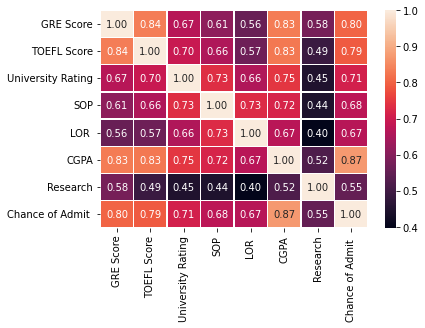

In [4]:
sns.heatmap(data.corr(),annot=True,linewidths=0.5,fmt='.2f') 
plt.show()

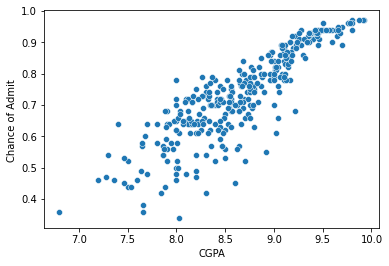

In [5]:
sns.scatterplot(x='CGPA',y='Chance of Admit ',data=train)
plt.show()

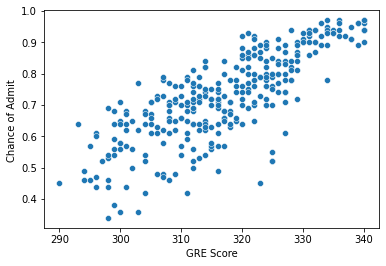

In [6]:
sns.scatterplot(x='GRE Score',y='Chance of Admit ',data=train)
plt.show()

In [7]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):

        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, (self.hidden_nodes, self.output_nodes))
        
        self.lr = learning_rate
        
        self.activation_function = lambda x : 1 / (np.exp(-x) + 1)
        
    def train(self, features, targets):

        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implement the forward pass function below
            # Implement the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y,delta_weights_i_h, 
                                                                                                            delta_weights_h_o)
        
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)


    def forward_pass_train(self, X):

        #### Implement the forward pass here ####
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # signals into hidden layer
        
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs, hidden_outputs

    
    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):

        #### Implement the backward pass here ####
        error = y - final_outputs # Output layer error is the difference between desired target and actual output.
        
        output_error_term = error 
        
        hidden_error = np.dot(self.weights_hidden_to_output, error)
      
        hidden_error_term = hidden_error * (hidden_outputs * (1 - hidden_outputs))
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:,None] 
        
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:,None]
        
        return delta_weights_i_h, delta_weights_h_o

    
    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):

        self.weights_hidden_to_output += self.lr * (delta_weights_h_o / n_records) # update hidden-to-output weights with gradient descent step
        
        self.weights_input_to_hidden +=  self.lr * (delta_weights_i_h / n_records) # update input-to-hidden weights with gradient descent step

        
    def run(self, features):
        
        #### Implement the forward pass here ####
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # signals into hidden layer
        
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer
        
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # signals into final output layer
        
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs


In [10]:
iterations = 1000
learning_rate = 0.05
hidden_nodes = 10
output_nodes = 1
def MSE(y, Y):
    return np.mean((y-Y)**2)

In [11]:
N_i = train_ft.shape[1]

network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    batch = np.random.choice(train_ft.index, size=128)
    X, y = train_ft.iloc[batch].values, train_tg.iloc[batch]['Chance of Admit ']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(np.array(network.run(train_ft)).T, train_tg['Chance of Admit '].values)
    
    val_loss = MSE(np.array(network.run(val_ft)).T, val_tg['Chance of Admit '].values)
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.9% ... Training loss: 0.010 ... Validation loss: 0.005

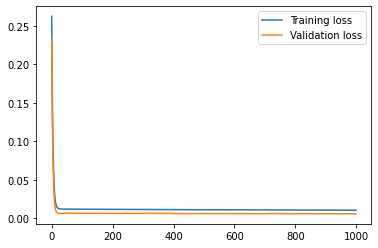

In [12]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

In [13]:
test_loss = MSE(np.array(network.run(test_ft)).T, test_tg['Chance of Admit '].values)
    
sys.stdout.write("Test loss: " + str(test_loss)[:5])
sys.stdout.flush()

Test loss: 0.010

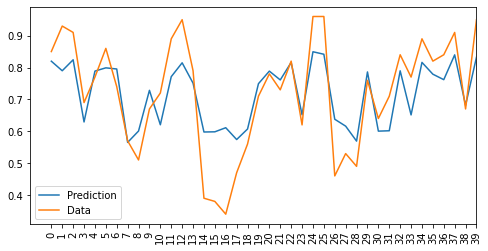

In [14]:
fig, ax = plt.subplots(figsize=(8,4))

predictions = np.array(network.run(test_ft)).T
ax.plot(predictions[0], label='Prediction')
ax.plot((test_tg['Chance of Admit ']).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

ax.set_xticks(np.arange(0,40))
_ = ax.set_xticklabels(np.arange(0,40), rotation=90)